In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import numpy as np
import scipy as sp 
import scipy.ndimage as ndimage
import math
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
import warnings

import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import pandas as pd
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, make_scorer, roc_auc_score, roc_curve, auc, accuracy_score, classification_report


import seaborn as sns
import random
from glob import glob
from PIL import Image
from tqdm import tqdm
from sklearn.utils import shuffle

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

In [17]:
# # Function to extract intensity-based features
# def extract_intensity_features (original_roi):
#     mean_intensity = np.mean(original_roi)
#     std_intensity = np.std(original_roi)
#     max_intensity = np.max(original_roi)
#     min_intensity = np.min(original_roi)
#     intensity_features = {
#         'mean_intensity': mean_intensity,
#         'std_intensity': std_intensity,
#         'max_intensity': max_intensity,
#         'min_intensity': min_intensity
#     }
#     return intensity_features


# # Function to extract Gray-Level Co-occurrence Matrix (GLCM) features
# def extract_glcm_features(original_roi):
#     glcm_features = pd.DataFrame()
#     params = [(1, 0), (2, 0),
#               (1, np.pi/4), (2, np.pi/4),
#               (1, np.pi/2), (2, np.pi/2)]
#     for i, (d, a) in enumerate(params):
#         GLCM = graycomatrix(original_roi, [d], [a])
#         GLCM_Energy = graycoprops(GLCM, 'energy')[0]
#         glcm_features['Energy'+str(i+1)] = GLCM_Energy
#         GLCM_corr = graycoprops(GLCM, 'correlation')[0]
#         glcm_features['Correlation'+str(i+1)] = GLCM_corr
#         GLCM_diss = graycoprops(GLCM, 'dissimilarity')[0]
#         glcm_features['Dissimilarity'+str(i+1)] = GLCM_diss
#         GLCM_hom = graycoprops(GLCM, 'homogeneity')[0]
#         glcm_features['Homogeneity'+str(i+1)] = GLCM_hom
#         GLCM_contr = graycoprops(GLCM, 'contrast')[0]
#         glcm_features['Contrast'+str(i+1)] = GLCM_contr
#     return glcm_features


# # Function to extract Gabor filter features
# def extract_gabor_feature(original_roi):
#    # img_gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
#     kernels = []
#     for theta in range(4):
#         theta = theta / 4. * np.pi
#         for sigma in (1, 3):
#             for frequency in (0.05, 0.25):
#                 kernel = np.real(gabor_kernel(frequency, theta=theta, sigma_x=sigma, sigma_y=sigma))
#                 kernels.append(kernel)
#     gabor_features1 = np.zeros((len(kernels), 2), dtype=np.double)
#     for k, kernel in enumerate(kernels):
#         filtered = ndi.convolve(original_roi, kernel, mode='wrap')
#         gabor_features1[k, 0] = filtered.mean()
#         gabor_features1[k, 1] = filtered.var()
#     gabor_features1 = gabor_features1.flatten()
#     gabor_features = {f'Gabor{i}': gabor_features1[i] for i in range(len(gabor_features1))}
#     return gabor_features

from skimage.filters import gabor_kernel
from scipy.ndimage import gaussian_filter

def extract_gabor_feature(original_roi):
    # Convert the image to grayscale if it's not already
    
      # Convert 'original_roi' to a NumPy array if it's an 'Image' object
    if isinstance(original_roi, Image.Image):
        original_roi = np.array(original_roi)

    if original_roi.ndim == 3:
        original_roi = cv2.cvtColor(original_roi, cv2.COLOR_RGB2GRAY)

    kernels = []
    for theta in range(4):
        theta = theta / 4. * np.pi
        for sigma in (1, 3):
            for frequency in (0.05, 0.25):
                kernel = np.real(gabor_kernel(frequency, theta=theta, sigma_x=sigma, sigma_y=sigma))
                kernels.append(kernel)

    gabor_features = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndimage.convolve(original_roi, kernel, mode='wrap')
        gabor_features[k, 0] = filtered.mean()
        gabor_features[k, 1] = filtered.var()

    gabor_features = gabor_features.flatten()
    gabor_feature_dict = {f'Gabor{i}': gabor_features[i] for i in range(len(gabor_features))}
    
    return gabor_feature_dict

# # Function to extract the Hu Moments
# def extract_hu_moments(roi_proc):
#     moments = cv2.moments(roi_proc)
#     hu_moments = cv2.HuMoments(moments)
#     hu_moments = np.array(hu_moments).reshape(1, -1)
#     hu_features = pd.DataFrame(hu_moments, columns=['Hu_moment'+str(i) for i in range(hu_moments.shape[1])])
#     return hu_features

# # Function to extract geometric shape descriptors
# def extract_shape_feature(region, w, h):
#     shape_features = pd.DataFrame()
#     area = cv2.contourArea(region)
#     perimeter = cv2.arcLength(region, True)
#     eccentricity = w/h
#     shape_features['Area'] = [area]
#     shape_features['Perimeter'] = [perimeter]
#     shape_features['Eccentricity'] = [eccentricity]
#     return shape_features

# # Overall function to combine all the extracted features and build the labels from the IoU
# def all_candidates_region_selection(original_img, processed_img, groundtruth):
#     contours, hierarchy = cv2.findContours(processed_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
#     idx = 0
#     intensity_features = pd.DataFrame()
#     glcm_features = pd.DataFrame()
#     gabor_features = pd.DataFrame()
#     hu_features = pd.DataFrame()
#     shape_features = pd.DataFrame()
#     iou_list = []
#     label_list = []
#     image_features = pd.DataFrame()
#     region_number = 1

#     for cnt in contours:
#         idx += 1
#         x, y, w, h = cv2.boundingRect(cnt)
#         roi_proc_img = processed_img[y:y+h, x:x+w]
#         roi_mask = groundtruth[y:y+h, x:x+w]
#         iou = evaluation(roi_proc_img, roi_mask)
#         b, g, r = cv2.split(original_img)

#         warnings.filterwarnings("ignore", category=FutureWarning)
        
#         # Call the functions to extract the images
#         intensity_features = intensity_features.append(extract_intensity_features(g[y:y+h, x:x+w]), ignore_index=True)
#         glcm_features = glcm_features.append(extract_glcm_features(g[y:y+h, x:x+w]), ignore_index=True)
#         gabor_features = gabor_features.append(extract_gabor_feature(g[y:y+h, x:x+w]), ignore_index=True)
#         hu_features = hu_features.append(extract_hu_moments(roi_proc_img), ignore_index=True)
#         shape_features = shape_features.append(extract_shape_feature(cnt, w, h), ignore_index=True)
        
#         # Combine all the features into one data frame
#         image_features = pd.concat([intensity_features, glcm_features, gabor_features, hu_features, shape_features], axis=1)
        
#         # Create IoU list and assign label 1 for IOU >= 0.5, otherwise 0
#         iou_list.append(iou)
#         label = 1 if iou >= 0.5 else 0 
#         label_list.append(label)
#         region_number += 1

#     # Add Image number and Region number columns
#     image_features.insert(0, 'Image number', image_number)
#     image_features.insert(1, 'Region', range(1, region_number))

#     return image_features, label_list


# # Save the data to CSV file
# def save_features_to_csv(dataframe, file_name, header=True):
#     if os.path.isfile(file_name):
#         # If the file already exists, append the data to it
#         dataframe.to_csv(file_name, mode='a', header=False, index=False)
#     else:
#         # If the file does not exist, create it and write the data to it
#         dataframe.to_csv(file_name, mode='w', header=True, index=False)

In [3]:
# Define file path
tr_dir_path = "train"
tr_nevus = os.path.join(tr_dir_path, "nevus")                                      
tr_others = os.path.join(tr_dir_path, "others")                                   

In [4]:
# Initialize lists to store data
tr_image_names = []; tr_image_files = []; tr_gtruth = []

# Define the target size for resizing
target_size = (256, 256)

# Function to resize and load images
def load_and_resize_image(file_path):
    img = Image.open(file_path)
    img = img.resize(target_size)
    return img


# For nevus images (groundtruth = 0)
for nevus_img in tqdm(os.listdir(tr_nevus), desc = "Nevus"):
    tr_image_names.append(nevus_img)
    tr_image_files.append(os.path.join(tr_nevus, nevus_img))
    tr_gtruth.append(0)
    
# For others images (groundtruth = 1)
for others_img in tqdm(os.listdir(tr_others), desc = "Others"):
    tr_image_names.append(others_img)
    tr_image_files.append(os.path.join(tr_others, others_img))
    tr_gtruth.append(1)
    

Others: 100%|██████████| 7470/7470 [00:00<00:00, 229326.11it/s]


In [5]:
# Create a dataframe
tr_data = {"tr_img_name":tr_image_names, "tr_img_file":tr_image_files, "tr_gtruth":tr_gtruth}
tr_df = pd.DataFrame(tr_data)
tr_df = shuffle(tr_df).reset_index(drop=True)
# Resize images
tr_df['resized_images'] = tr_df['tr_img_file'].apply(load_and_resize_image)

tr_df.head()

,tr_img_name,tr_img_file,tr_gtruth,resized_images
0,mel02135.jpg,train\others\mel02135.jpg,1,<PIL.Image.Image image mode=RGB size=256x256 a...
1,nev03224.jpg,train\nevus\nev03224.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...
2,nev06525.jpg,train\nevus\nev06525.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...
3,bkl00551.jpg,train\others\bkl00551.jpg,1,<PIL.Image.Image image mode=RGB size=256x256 a...
4,nev06198.jpg,train\nevus\nev06198.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...


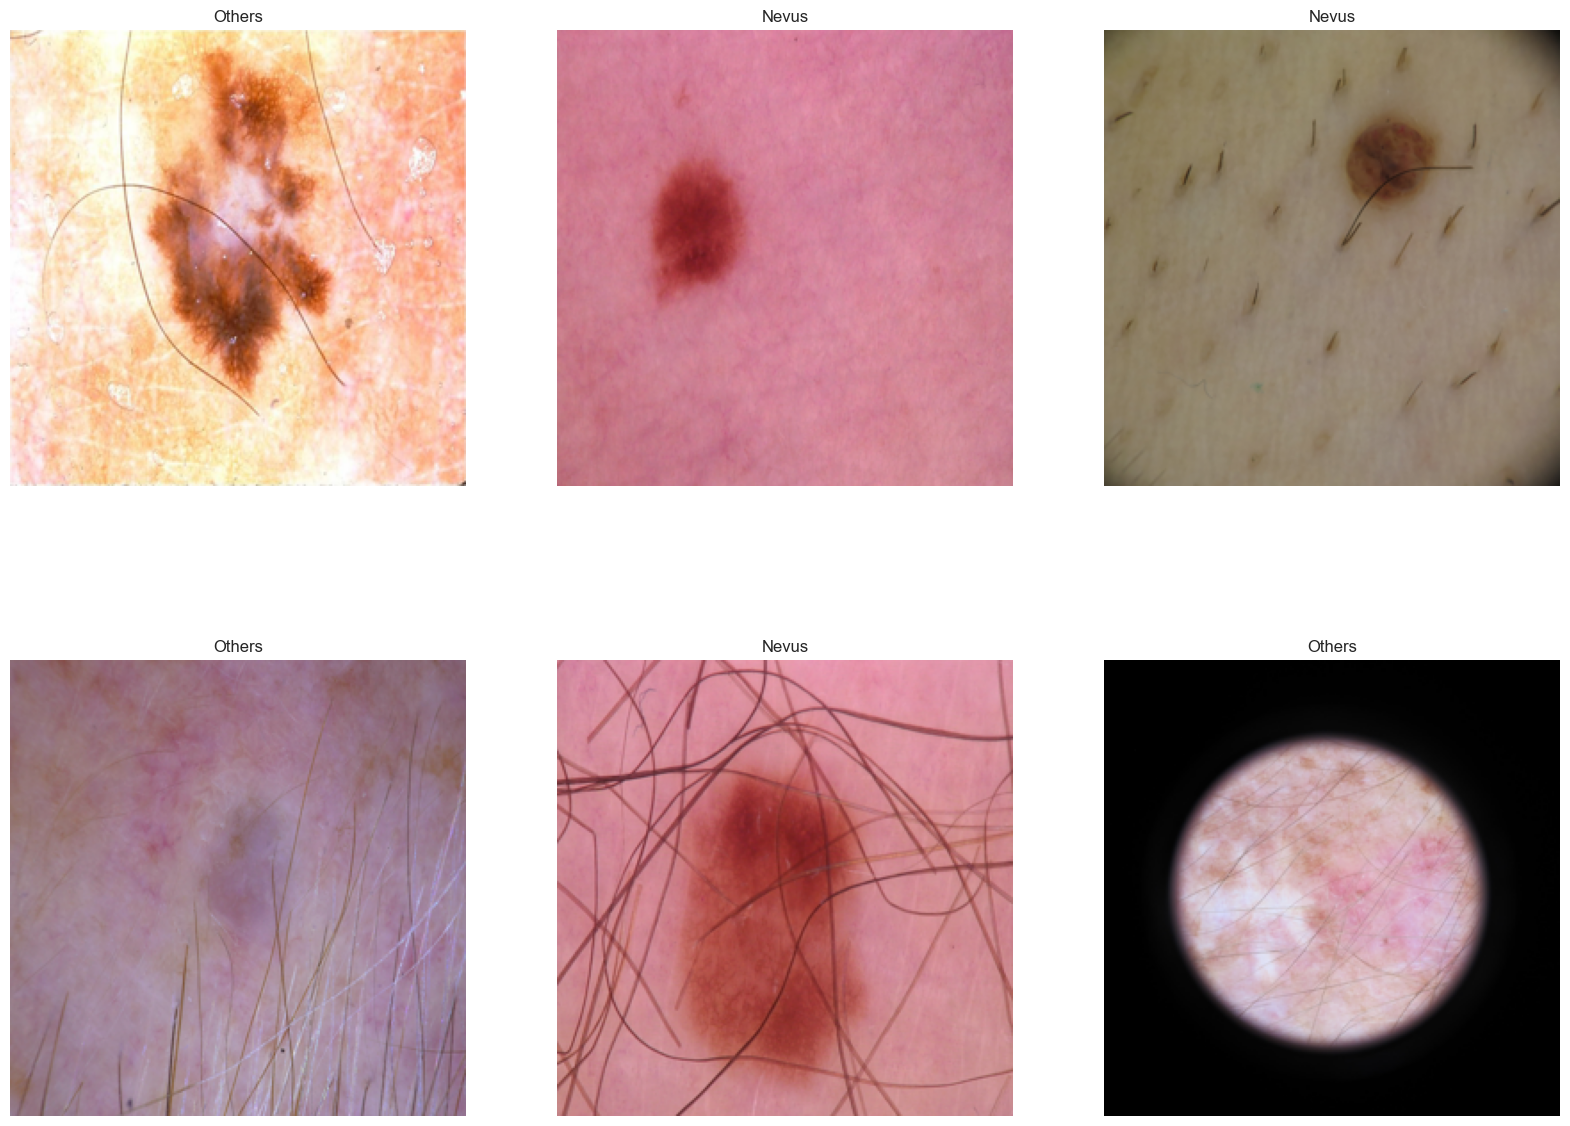

In [6]:
# Set the seaborn style
sns.set_style("white")

# Create a figure
plt.figure(figsize=[20, 15])

for i, (image_path, ground_truth) in enumerate(zip(tr_df["resized_images"][:6], tr_df["tr_gtruth"][:6])):
    # Set the title based on ground truth
    title = "Nevus" if ground_truth == 0 else "Others"
    
    # Plot the image
    plt.subplot(2, 3, i + 1)
    plt.imshow(image_path)
    plt.axis("off")
    plt.title(title)

plt.show()

In [18]:
# intensity_features = pd.DataFrame()
# intensity_features = intensity_features.append(extract_intensity_features(tr_df['resized_images']), ignore_index=True)

# # Combine all the features into one data frame
# train_df = pd.concat([intensity_features, tr_df], axis=1)

gabor_features = pd.DataFrame()
gabor_features_list = []

for index, row in tr_df.iterrows():
    resized_image = row['resized_images']
    features =  extract_gabor_feature(resized_image)
    gabor_features_list.append(pd.DataFrame(features, index=[0]))

gabor_features = pd.concat(gabor_features_list, ignore_index=True)

# Combine intensity features with the original DataFrame
train_df = pd.concat([tr_df, gabor_features], axis=1)
train_df.head()

,tr_img_name,tr_img_file,tr_gtruth,resized_images,Gabor0,Gabor1,Gabor2,Gabor3,Gabor4,Gabor5,...,Gabor22,Gabor23,Gabor24,Gabor25,Gabor26,Gabor27,Gabor28,Gabor29,Gabor30,Gabor31
0,mel02135.jpg,train\others\mel02135.jpg,1,<PIL.Image.Image image mode=RGB size=256x256 a...,197.649155,1222.335510,60.074127,123.103544,133.165497,529.533738,...,7.153183,1750.177570,197.651917,1222.218376,60.159866,122.447389,134.323074,534.062722,11.971436,2880.656166
1,nev03224.jpg,train\nevus\nev03224.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...,143.007584,239.565296,43.371262,23.200528,96.305176,106.047065,...,0.333313,84.228716,143.009003,239.512004,43.432541,23.043484,97.144913,107.069927,0.019501,4.960679
2,nev06525.jpg,train\nevus\nev06525.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...,121.237610,201.286284,36.714706,20.190260,81.621521,86.909488,...,0.539795,135.405673,121.238983,201.149827,36.768250,19.484835,82.333069,86.858456,0.046951,11.904488
3,bkl00551.jpg,train\others\bkl00551.jpg,1,<PIL.Image.Image image mode=RGB size=256x256 a...,130.459198,163.344740,39.535172,20.465072,87.840530,67.732794,...,2.617996,655.842492,130.460144,162.983122,39.588699,16.877692,88.605972,67.753113,0.207047,52.452356
4,nev06198.jpg,train\nevus\nev06198.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...,133.855225,708.797247,40.575043,78.152022,90.130096,287.612592,...,13.589920,3234.134248,133.856674,708.460796,40.629929,75.672358,90.917160,291.612141,13.869553,3300.995664


In [19]:
train_df.head()

,tr_img_name,tr_img_file,tr_gtruth,resized_images,Gabor0,Gabor1,Gabor2,Gabor3,Gabor4,Gabor5,...,Gabor22,Gabor23,Gabor24,Gabor25,Gabor26,Gabor27,Gabor28,Gabor29,Gabor30,Gabor31
0,mel02135.jpg,train\others\mel02135.jpg,1,<PIL.Image.Image image mode=RGB size=256x256 a...,197.649155,1222.335510,60.074127,123.103544,133.165497,529.533738,...,7.153183,1750.177570,197.651917,1222.218376,60.159866,122.447389,134.323074,534.062722,11.971436,2880.656166
1,nev03224.jpg,train\nevus\nev03224.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...,143.007584,239.565296,43.371262,23.200528,96.305176,106.047065,...,0.333313,84.228716,143.009003,239.512004,43.432541,23.043484,97.144913,107.069927,0.019501,4.960679
2,nev06525.jpg,train\nevus\nev06525.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...,121.237610,201.286284,36.714706,20.190260,81.621521,86.909488,...,0.539795,135.405673,121.238983,201.149827,36.768250,19.484835,82.333069,86.858456,0.046951,11.904488
3,bkl00551.jpg,train\others\bkl00551.jpg,1,<PIL.Image.Image image mode=RGB size=256x256 a...,130.459198,163.344740,39.535172,20.465072,87.840530,67.732794,...,2.617996,655.842492,130.460144,162.983122,39.588699,16.877692,88.605972,67.753113,0.207047,52.452356
4,nev06198.jpg,train\nevus\nev06198.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...,133.855225,708.797247,40.575043,78.152022,90.130096,287.612592,...,13.589920,3234.134248,133.856674,708.460796,40.629929,75.672358,90.917160,291.612141,13.869553,3300.995664


In [20]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15195 entries, 0 to 15194
Data columns (total 36 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tr_img_name     15195 non-null  object 
 1   tr_img_file     15195 non-null  object 
 2   tr_gtruth       15195 non-null  int64  
 3   resized_images  15195 non-null  object 
 4   Gabor0          15195 non-null  float64
 5   Gabor1          15195 non-null  float64
 6   Gabor2          15195 non-null  float64
 7   Gabor3          15195 non-null  float64
 8   Gabor4          15195 non-null  float64
 9   Gabor5          15195 non-null  float64
 10  Gabor6          15195 non-null  float64
 11  Gabor7          15195 non-null  float64
 12  Gabor8          15195 non-null  float64
 13  Gabor9          15195 non-null  float64
 14  Gabor10         15195 non-null  float64
 15  Gabor11         15195 non-null  float64
 16  Gabor12         15195 non-null  float64
 17  Gabor13         15195 non-null 

In [21]:
# Define file path for validation set
val_dir_path = "val"
val_nevus = os.path.join(val_dir_path, "nevus")
val_others = os.path.join(val_dir_path, "others")

# Initialize lists to store validation data
val_image_names = []
val_image_files = []
val_gtruth = []

# For nevus images in the validation set (groundtruth = 0)
for nevus_img in tqdm(os.listdir(val_nevus), desc="Nevus"):
    val_image_names.append(nevus_img)
    val_image_files.append(os.path.join(val_nevus, nevus_img))
    val_gtruth.append(0)

# For others images in the validation set (groundtruth = 1)
for others_img in tqdm(os.listdir(val_others), desc="Others"):
    val_image_names.append(others_img)
    val_image_files.append(os.path.join(val_others, others_img))
    val_gtruth.append(1)

# Create a DataFrame for validation data
val_data = {"val_img_name": val_image_names, "val_img_file": val_image_files, "val_gtruth": val_gtruth}
val_df = pd.DataFrame(val_data)

# Shuffle the validation DataFrame
val_df = shuffle(val_df).reset_index(drop=True)

# Resize images for validation set
val_df['resized_images'] = val_df['val_img_file'].apply(load_and_resize_image)

# Display the first few rows of the validation DataFrame
val_df.head()

Others: 100%|██████████| 1865/1865 [00:00<00:00, 159166.10it/s]


,val_img_name,val_img_file,val_gtruth,resized_images
0,mel03258.jpg,val\others\mel03258.jpg,1,<PIL.Image.Image image mode=RGB size=256x256 a...
1,nev08958.jpg,val\nevus\nev08958.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...
2,nev08621.jpg,val\nevus\nev08621.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...
3,bcc02424.jpg,val\others\bcc02424.jpg,1,<PIL.Image.Image image mode=RGB size=256x256 a...
4,bcc02097.jpg,val\others\bcc02097.jpg,1,<PIL.Image.Image image mode=RGB size=256x256 a...


In [22]:
val_gabor_features = pd.DataFrame()
val_gabor_features_list = []

for index, row in val_df.iterrows():
    val_resized_image = row['resized_images']
    val_features = extract_gabor_feature(val_resized_image)
    val_gabor_features_list.append(pd.DataFrame(val_features, index=[0]))

val_gabor_features = pd.concat(val_gabor_features_list, ignore_index=True)

# Combine intensity features with the original DataFrame
validation_df = pd.concat([val_df, val_gabor_features], axis=1)
validation_df.head()

,val_img_name,val_img_file,val_gtruth,resized_images,Gabor0,Gabor1,Gabor2,Gabor3,Gabor4,Gabor5,...,Gabor22,Gabor23,Gabor24,Gabor25,Gabor26,Gabor27,Gabor28,Gabor29,Gabor30,Gabor31
0,mel03258.jpg,val\others\mel03258.jpg,1,<PIL.Image.Image image mode=RGB size=256x256 a...,118.338699,5141.986891,35.830002,489.910477,79.665390,2240.589559,...,19.522583,4503.397683,118.338699,5143.357802,35.878723,494.102846,80.357056,2285.874434,13.053970,3137.645815
1,nev08958.jpg,val\nevus\nev08958.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...,179.341125,64.527951,54.478180,6.554700,120.814896,27.285851,...,0.492859,123.788920,179.343460,64.521638,54.556564,6.583104,121.866043,27.528824,0.035110,8.928684
2,nev08621.jpg,val\nevus\nev08621.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...,138.976913,885.751710,42.142670,85.353913,93.585968,397.029597,...,0.455276,114.669142,138.977982,885.637745,42.197342,84.368145,94.401566,402.221603,1.164368,293.059562
3,bcc02424.jpg,val\others\bcc02424.jpg,1,<PIL.Image.Image image mode=RGB size=256x256 a...,131.010071,910.869619,39.703583,88.088010,88.213013,399.691534,...,10.380722,2516.370264,131.011124,910.727736,39.760284,87.372315,88.982590,405.866778,1.231354,310.940708
4,bcc02097.jpg,val\others\bcc02097.jpg,1,<PIL.Image.Image image mode=RGB size=256x256 a...,154.711319,329.165000,46.947403,31.547084,104.201797,144.985813,...,0.592056,149.284281,154.712708,329.163038,47.015045,31.637164,105.108932,147.405904,0.417999,105.938588


In [23]:
train_features = train_df.drop(columns=['tr_img_name', 'tr_img_file', 'resized_images', 'tr_gtruth'])
train_labels = train_df['tr_gtruth']

validation_features = validation_df.drop(columns=['val_img_name', 'val_img_file', 'resized_images', 'val_gtruth'])
validation_labels = validation_df['val_gtruth']

In [24]:
# Define features and labels for training
X_train = train_features
y_train = train_labels

# Define features and labels for validation
X_val = validation_features
y_val = validation_labels

# Standardize the data
X_train_scaled = StandardScaler().fit_transform(X_train)
X_val_scaled = StandardScaler().fit_transform(X_val)

# Display the first few rows of the standardized data
print("Standardized Training Features:")
pd.DataFrame(X_train_scaled, columns=X_train.columns).head()

Standardized Training Features:


,Gabor0,Gabor1,Gabor2,Gabor3,Gabor4,Gabor5,Gabor6,Gabor7,Gabor8,Gabor9,...,Gabor22,Gabor23,Gabor24,Gabor25,Gabor26,Gabor27,Gabor28,Gabor29,Gabor30,Gabor31
0,2.075893,-0.192869,2.079595,-0.177243,2.076848,-0.207981,2.264896,2.395467,2.075836,-0.193113,...,0.965259,1.053643,2.075928,-0.192921,2.079934,-0.165622,2.076824,-0.212114,1.795871,1.936495
1,0.179288,-0.736045,0.175835,-0.752469,0.179106,-0.730829,-0.670124,-0.726268,0.179268,-0.736028,...,-0.586673,-0.626397,0.179293,-0.736048,0.177774,-0.747526,0.179193,-0.730670,-0.544038,-0.586812
2,-0.576346,-0.757202,-0.582866,-0.769801,-0.576878,-0.754457,-0.247245,-0.248510,-0.576306,-0.757184,...,-0.539686,-0.574788,-0.576337,-0.757250,-0.580061,-0.768358,-0.576827,-0.755215,-0.538664,-0.580719
3,-0.256265,-0.778172,-0.261395,-0.768219,-0.256694,-0.778133,2.675878,2.803142,-0.256279,-0.778234,...,-0.066770,-0.049949,-0.256273,-0.778345,-0.259331,-0.783620,-0.256648,-0.778417,-0.507321,-0.545140
4,-0.138390,-0.476701,-0.142872,-0.436067,-0.138816,-0.506664,2.543862,2.672614,-0.138325,-0.476642,...,2.430005,2.550152,-0.138381,-0.476867,-0.140927,-0.439440,-0.138681,-0.506555,2.167478,2.305326


In [25]:
print("\nStandardized Validation Features:")
pd.DataFrame(X_val_scaled, columns=X_val.columns).head()


Standardized Validation Features:


,Gabor0,Gabor1,Gabor2,Gabor3,Gabor4,Gabor5,Gabor6,Gabor7,Gabor8,Gabor9,...,Gabor22,Gabor23,Gabor24,Gabor25,Gabor26,Gabor27,Gabor28,Gabor29,Gabor30,Gabor31
0,-0.678679,1.916381,-0.685046,1.893198,-0.679328,1.847784,2.101620,2.211318,-0.678651,1.917158,...,3.740444,3.746584,-0.678716,1.917086,-0.682737,1.955510,-0.679398,1.858532,1.930110,2.079632
1,1.448008,-0.848817,1.448888,-0.867463,1.448516,-0.844277,-0.677668,-0.724157,1.448005,-0.848811,...,-0.554324,-0.583836,1.448034,-0.848793,1.450139,-0.859449,1.448575,-0.843475,-0.535681,-0.576449
2,0.040817,-0.401576,0.037320,-0.417405,0.040506,-0.394554,0.133006,0.169549,0.040810,-0.401592,...,-0.562806,-0.592854,0.040811,-0.401622,0.038804,-0.410315,0.040599,-0.395172,-0.321798,-0.335240
3,-0.236926,-0.387897,-0.241788,-0.401790,-0.237329,-0.391317,0.018253,0.045517,-0.236934,-0.387722,...,1.677242,1.781873,-0.236930,-0.387958,-0.239491,-0.392968,-0.237207,-0.390811,-0.309111,-0.320060
4,0.589355,-0.704695,0.587132,-0.724720,0.589452,-0.701118,-0.607698,-0.645741,0.589366,-0.704693,...,-0.531937,-0.558627,0.589356,-0.704672,0.588952,-0.714785,0.589516,-0.700047,-0.463161,-0.494094


In [27]:
# Apply PCA
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

# Display the first few rows of the PCA-transformed data
print("PCA-transformed Training Features:")
pd.DataFrame(X_train_pca).head()

PCA-transformed Training Features:


,0,1,2,3,4,5,6,7,8,9
0,-5.270366,4.953646,-4.480218,-1.183851,1.000213,0.207334,-0.121380,0.046889,-0.123355,0.017530
1,-2.354374,-1.594352,1.342200,0.165730,-0.021099,-0.165534,0.022485,-0.005821,0.048674,-0.003296
2,-0.514034,-1.054543,3.266278,-0.305064,-0.400603,-0.171327,0.024585,0.011802,0.011616,-0.000237
3,-1.222733,1.641956,2.675505,-2.842054,-0.012822,2.047622,-0.164757,0.098170,-0.026004,0.004301
4,-0.340875,6.958677,1.626693,-0.131499,-0.220130,0.268811,-0.108098,0.033586,-0.132468,0.020794


In [28]:
# Define classifiers
rf_classifier = RandomForestClassifier(random_state=42)
svm_classifier = SVC(kernel='rbf', C=1, gamma='auto', random_state=42)
knn_classifier = KNeighborsClassifier(n_neighbors=5)
logreg_classifier = LogisticRegression(random_state=42)
adaboost_classifier = AdaBoostClassifier(random_state=42)
nb_classifier = GaussianNB()

# Combine classifiers in a dictionary
classifiers = {
    'Random Forest': rf_classifier,
    'SVM': svm_classifier,
    'k-NN': knn_classifier,
    'Logistic Regression': logreg_classifier,
    'AdaBoost': adaboost_classifier,
    'Naive Bayes': nb_classifier
}

# Perform 10-fold cross-validation and predictions for each classifier
for clf_name, clf in classifiers.items():
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
    # Perform cross-validation
    cv_results = cross_val_score(clf, X_train_pca, y_train, cv=skf)
    
    # Print cross-validation results
    print(f"\nClassifier: {clf_name}")
    print("Cross-validation Results:", cv_results)
    print("Average Cross-validation Accuracy:", np.mean(cv_results))
    
    # Fit the model on the entire training set (no need for additional scaling)
    clf.fit(X_train_pca, y_train)
    
    # Make predictions on the validation set
    y_pred_val = clf.predict(X_val_pca)
    
    # Evaluate the model
    acc_train = accuracy_score(y_train, clf.predict(X_train_pca))
    acc_val = accuracy_score(y_val, y_pred_val)
    
    print("\nEvaluation on Validation Set:")
    print("Training Accuracy:", acc_train)
    print("Validation Accuracy:", acc_val)
    
    # Print confusion matrix for validation set
    print("\nConfusion Matrix (Validation Set):")
    print(confusion_matrix(y_val, y_pred_val))
    
    # Print classification report for validation set
    print("\nClassification Report (Validation Set):")
    print(classification_report(y_val, y_pred_val))


Classifier: Random Forest
Cross-validation Results: [0.68684211 0.69539474 0.67828947 0.68355263 0.65197368 0.66951942
 0.67083608 0.6714944  0.68005267 0.69321922]
Average Cross-validation Accuracy: 0.6781174422230691

Evaluation on Validation Set:
Training Accuracy: 1.0
Validation Accuracy: 0.6701791359325606

Confusion Matrix (Validation Set):
[[1285  646]
 [ 606 1259]]

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.68      0.67      0.67      1931
           1       0.66      0.68      0.67      1865

    accuracy                           0.67      3796
   macro avg       0.67      0.67      0.67      3796
weighted avg       0.67      0.67      0.67      3796


Classifier: SVM
Cross-validation Results: [0.6625     0.65592105 0.6625     0.65328947 0.63881579 0.6524029
 0.6524029  0.64845293 0.63791968 0.64516129]
Average Cross-validation Accuracy: 0.6509366012958664

Evaluation on Validation Set:
Training Accura